In [38]:
# Core PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# Data handling
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# Models
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import numpy as np
from tqdm import tqdm
import os

In [39]:
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

print("Using device:", device)

Using device: mps


In [40]:
DATA_DIR = "asl_alphabet/asl_alphabet_train/asl_alphabet_train"
NUM_CLASSES = 29   # A–Z + del + space + nothing
BATCH_SIZE = 128  # Increased for faster training
IMG_SIZE = 160
EPOCHS = 10
LEARNING_RATE = 1e-4  # Lower initial LR for fine-tuning
WEIGHT_DECAY = 1e-4   # L2 regularization

In [41]:
base_dataset = datasets.ImageFolder(DATA_DIR)

print("Total images:", len(base_dataset))
print("Class names:", base_dataset.classes)

Total images: 87000
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [42]:
indices = np.arange(len(base_dataset))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=base_dataset.targets,
    random_state=42
)

print("Train samples:", len(train_idx))
print("Val samples:", len(val_idx))

Train samples: 69600
Val samples: 17400


In [43]:
class RandomGamma:
    def __init__(self, gamma_range=(0.7, 1.5)):
        self.gamma_range = gamma_range

    def __call__(self, img):
        gamma = torch.empty(1).uniform_(
            self.gamma_range[0], self.gamma_range[1]
        ).item()
        return transforms.functional.adjust_gamma(img, gamma)

In [48]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.3
    ),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    RandomGamma((0.7, 1.5)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [49]:
train_dataset = Subset(
    datasets.ImageFolder(DATA_DIR, transform=train_transform),
    train_idx
)

val_dataset = Subset(
    datasets.ImageFolder(DATA_DIR, transform=val_transform),
    val_idx
)

In [50]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020528376..1.05].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020528376..1.0095639].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020528376..1.05].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020528376..0.66797036].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020528376..1.05].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020528376..0.65457666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0205283

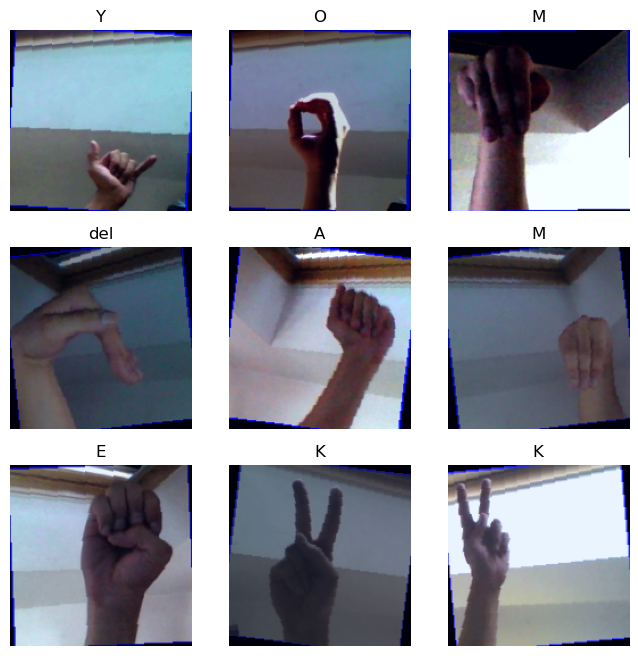

In [51]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = images[i].permute(1, 2, 0)
    img = img * 0.225 + 0.456
    plt.imshow(img)
    plt.title(base_dataset.classes[labels[i]])
    plt.axis("off")
plt.show()

In [52]:
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze early layers, unfreeze last few blocks for fine-tuning
# This allows better adaptation while keeping training time reasonable
features_list = list(model.features.children())
num_blocks = len(features_list)

# Freeze all feature layers initially
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze last 3 blocks for fine-tuning (these are the deeper, more task-specific layers)
for i in range(max(0, num_blocks - 3), num_blocks):
    for param in features_list[i].parameters():
        param.requires_grad = True

# Replace classifier
model.classifier[1] = nn.Linear(
    model.last_channel,
    NUM_CLASSES
)

# Always train classifier
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.1f}%)")

Trainable parameters: 1,243,229 / 2,261,021 (55.0%)


In [53]:
criterion = nn.CrossEntropyLoss()

# Use AdamW with weight decay for better regularization
# Train all unfrozen parameters (classifier + last few feature layers)
optimizer = optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler - reduces LR by 50% every 3 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [54]:
print("NUM_CLASSES variable:", NUM_CLASSES)
print("Detected classes:", len(base_dataset.classes))
print("Class names:", base_dataset.classes[:10], "...")

# count samples per class
counts = np.bincount(base_dataset.targets)
print("Min samples in a class:", counts.min())
print("Max samples in a class:", counts.max())
print("Total classes with >0 samples:", (counts > 0).sum())

NUM_CLASSES variable: 29
Detected classes: 29
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'] ...
Min samples in a class: 3000
Max samples in a class: 3000
Total classes with >0 samples: 29


In [55]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_correct, train_total = 0, 0
    train_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        train_loss += loss.item()

        loop.set_postfix(
            loss=f"{loss.item():.4f}",
            acc=f"{100 * train_correct / train_total:.2f}%",
            lr=f"{scheduler.get_last_lr()[0]:.6f}"
        )

    train_acc = 100 * train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_loss += loss.item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_accs.append(val_acc)
    val_losses.append(avg_val_loss)

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train: Loss={avg_train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"  Val:   Loss={avg_val_loss:.4f}, Acc={val_acc:.2f}%")
    print(f"  LR:    {scheduler.get_last_lr()[0]:.6f}\n")

Epoch 1/10 [Train]: 100%|██████████| 544/544 [07:00<00:00,  1.29it/s, acc=85.76%, loss=0.1682, lr=0.000100]


Epoch 1/10
  Train: Loss=0.6399, Acc=85.76%
  Val:   Loss=0.1072, Acc=97.80%
  LR:    0.000100



Epoch 2/10 [Train]: 100%|██████████| 544/544 [09:32<00:00,  1.05s/it, acc=97.40%, loss=0.0751, lr=0.000100]


Epoch 2/10
  Train: Loss=0.1042, Acc=97.40%
  Val:   Loss=0.0400, Acc=99.17%
  LR:    0.000100



Epoch 3/10 [Train]: 100%|██████████| 544/544 [07:36<00:00,  1.19it/s, acc=98.54%, loss=0.0295, lr=0.000100]


Epoch 3/10
  Train: Loss=0.0577, Acc=98.54%
  Val:   Loss=0.0254, Acc=99.34%
  LR:    0.000050



Epoch 4/10 [Train]: 100%|██████████| 544/544 [08:10<00:00,  1.11it/s, acc=99.00%, loss=0.0821, lr=0.000050]


Epoch 4/10
  Train: Loss=0.0387, Acc=99.00%
  Val:   Loss=0.0191, Acc=99.55%
  LR:    0.000050



Epoch 5/10 [Train]: 100%|██████████| 544/544 [07:34<00:00,  1.20it/s, acc=99.15%, loss=0.0576, lr=0.000050]


Epoch 5/10
  Train: Loss=0.0321, Acc=99.15%
  Val:   Loss=0.0143, Acc=99.71%
  LR:    0.000050



Epoch 6/10 [Train]: 100%|██████████| 544/544 [10:25<00:00,  1.15s/it, acc=99.32%, loss=0.0318, lr=0.000050]


Epoch 6/10
  Train: Loss=0.0266, Acc=99.32%
  Val:   Loss=0.0122, Acc=99.71%
  LR:    0.000025



Epoch 7/10 [Train]: 100%|██████████| 544/544 [09:30<00:00,  1.05s/it, acc=99.38%, loss=0.0273, lr=0.000025]


Epoch 7/10
  Train: Loss=0.0230, Acc=99.38%
  Val:   Loss=0.0106, Acc=99.72%
  LR:    0.000025



Epoch 8/10 [Train]: 100%|██████████| 544/544 [07:39<00:00,  1.18it/s, acc=99.45%, loss=0.0097, lr=0.000025]


Epoch 8/10
  Train: Loss=0.0207, Acc=99.45%
  Val:   Loss=0.0094, Acc=99.78%
  LR:    0.000025



Epoch 9/10 [Train]: 100%|██████████| 544/544 [06:37<00:00,  1.37it/s, acc=99.55%, loss=0.0457, lr=0.000025]


Epoch 9/10
  Train: Loss=0.0183, Acc=99.55%
  Val:   Loss=0.0087, Acc=99.79%
  LR:    0.000013



Epoch 10/10 [Train]: 100%|██████████| 544/544 [10:58<00:00,  1.21s/it, acc=99.56%, loss=0.0056, lr=0.000013]
                                                                    

Epoch 10/10
  Train: Loss=0.0169, Acc=99.56%
  Val:   Loss=0.0080, Acc=99.80%
  LR:    0.000013



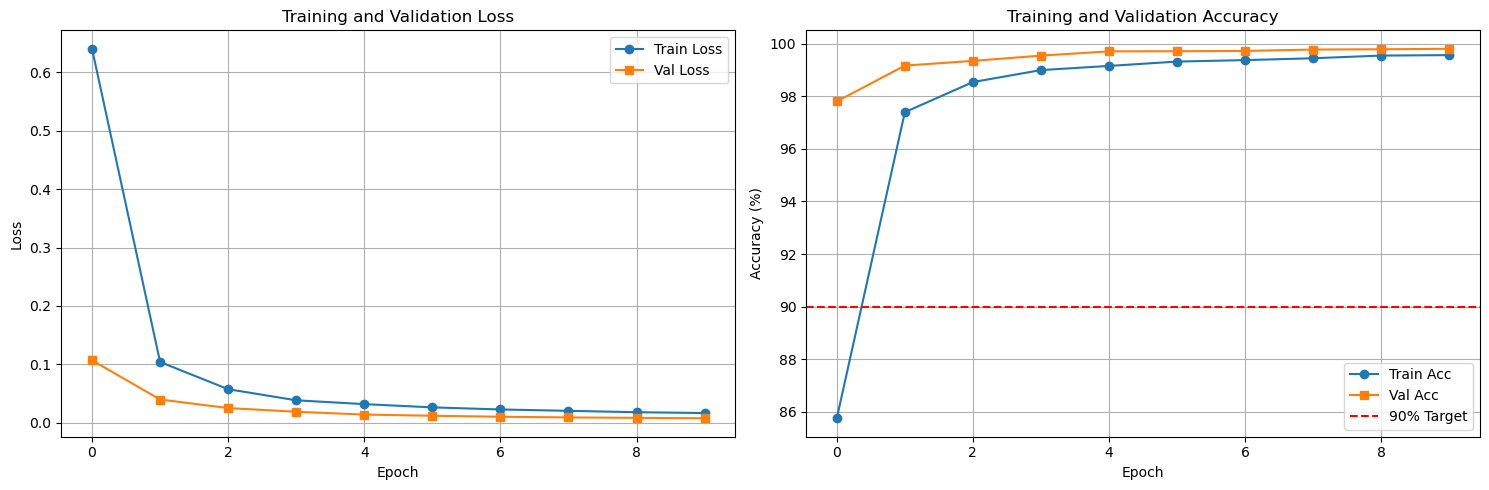


Final Validation Accuracy: 99.80%
Best Validation Accuracy: 99.80%


In [56]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', marker='o')
plt.plot(val_accs, label='Val Acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.axhline(y=90, color='r', linestyle='--', label='90% Target')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nFinal Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"Best Validation Accuracy: {max(val_accs):.2f}%")


Generating predictions: 100%|██████████| 136/136 [01:28<00:00,  1.53it/s]


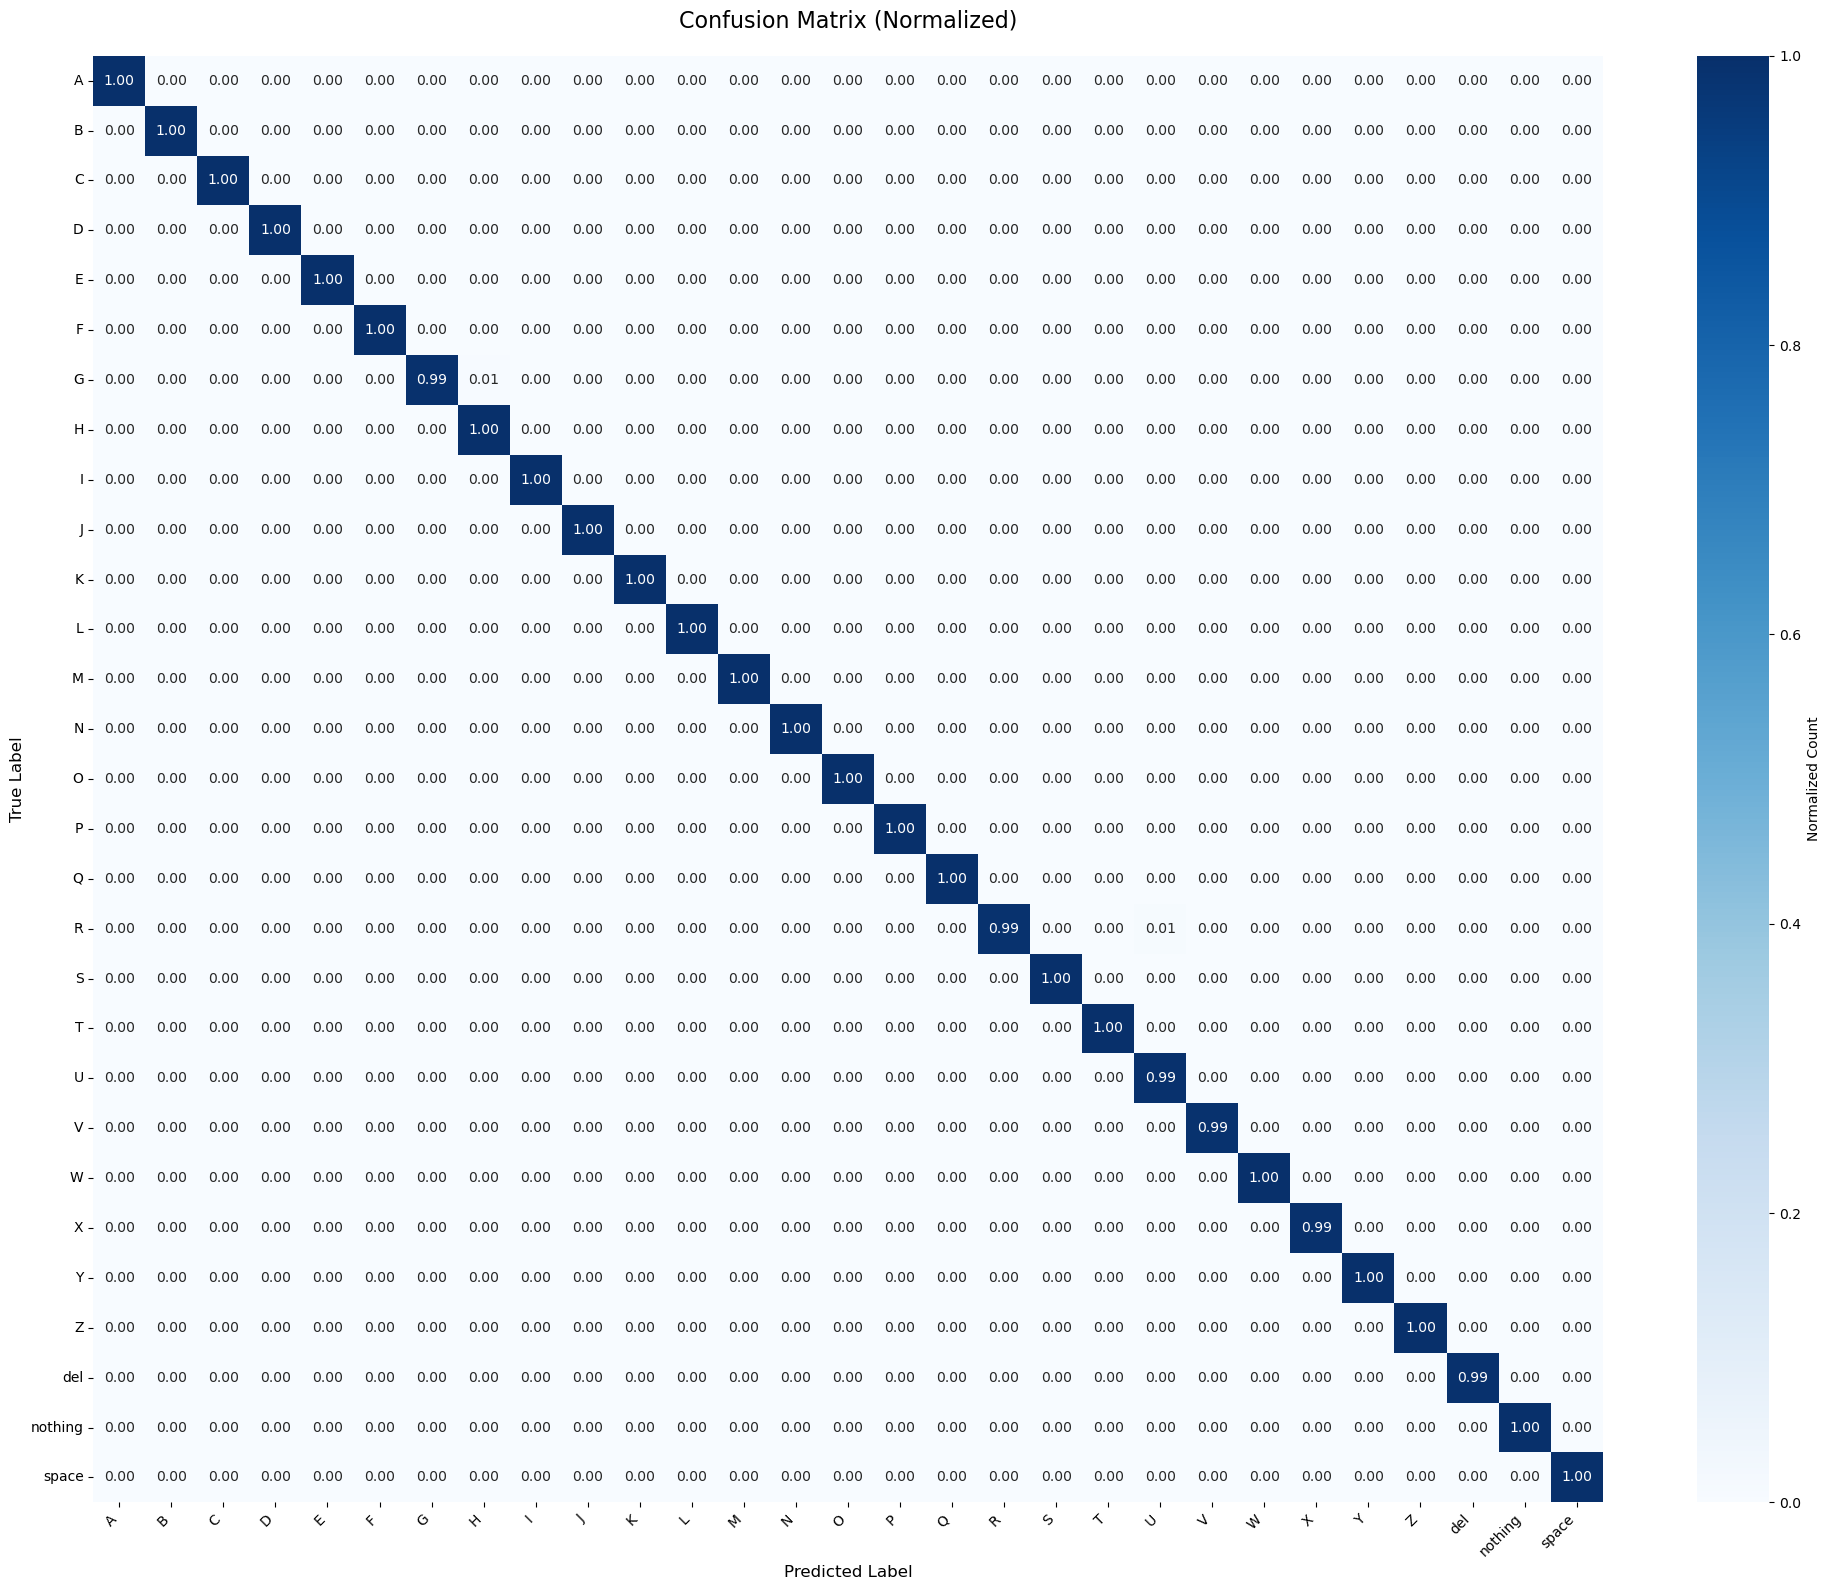


Per-Class Accuracy:
----------------------------------------
A       : 100.00% (  600/  600)
B       :  99.83% (  599/  600)
C       :  99.83% (  599/  600)
D       : 100.00% (  600/  600)
E       : 100.00% (  600/  600)
F       : 100.00% (  600/  600)
G       :  99.33% (  596/  600)
H       :  99.83% (  599/  600)
I       :  99.67% (  598/  600)
J       : 100.00% (  600/  600)
K       : 100.00% (  600/  600)
L       : 100.00% (  600/  600)
M       :  99.83% (  599/  600)
N       : 100.00% (  600/  600)
O       : 100.00% (  600/  600)
P       : 100.00% (  600/  600)
Q       :  99.83% (  599/  600)
R       :  98.83% (  593/  600)
S       :  99.67% (  598/  600)
T       : 100.00% (  600/  600)
U       :  99.50% (  597/  600)
V       :  99.17% (  595/  600)
W       : 100.00% (  600/  600)
X       :  99.50% (  597/  600)
Y       : 100.00% (  600/  600)
Z       : 100.00% (  600/  600)
del     :  99.50% (  597/  600)
nothing : 100.00% (  600/  600)
space   : 100.00% (  600/  600)
----------

In [57]:
# Generate confusion matrix on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Generating predictions"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=base_dataset.classes,
    yticklabels=base_dataset.classes,
    cbar_kws={'label': 'Normalized Count'}
)
plt.title('Confusion Matrix (Normalized)', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print per-class accuracy
print("\nPer-Class Accuracy:")
print("-" * 40)
for i, class_name in enumerate(base_dataset.classes):
    if cm[i].sum() > 0:
        class_acc = cm[i, i] / cm[i].sum() * 100
        print(f"{class_name:8s}: {class_acc:6.2f}% ({cm[i, i]:5d}/{cm[i].sum():5d})")
    else:
        print(f"{class_name:8s}: N/A (no samples)")

# Overall accuracy
overall_acc = np.trace(cm) / np.sum(cm) * 100
print("-" * 40)
print(f"{'Overall':8s}: {overall_acc:6.2f}%")

In [58]:
# ============================================
# EXPORT MODEL FOR EDGE DEPLOYMENT (Raspberry Pi / PCB)
# ============================================

# Create export directory
os.makedirs("exported_models", exist_ok=True)

# Save model metadata
model_info = {
    "num_classes": NUM_CLASSES,
    "img_size": IMG_SIZE,
    "class_names": base_dataset.classes,
    "mean": [0.485, 0.456, 0.406],
    "std": [0.229, 0.224, 0.225]
}

import json
with open("exported_models/model_info.json", "w") as f:
    json.dump(model_info, f, indent=2)

print("✓ Model metadata saved to exported_models/model_info.json")


✓ Model metadata saved to exported_models/model_info.json


In [59]:
# 1. Save PyTorch state dict (standard format - requires model architecture to load)
torch.save(model.state_dict(), "exported_models/asl_model.pth")
print("✓ PyTorch state dict saved: exported_models/asl_model.pth")
print(f"  File size: {os.path.getsize('exported_models/asl_model.pth') / (1024*1024):.2f} MB")


✓ PyTorch state dict saved: exported_models/asl_model.pth
  File size: 8.85 MB


In [64]:
# 2. Export to TorchScript (PyTorch's deployment format - like TFLite for PyTorch)
# This creates a standalone model that can run without Python code
model.eval()

# Create a dummy input with the correct shape
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)

# Export to TorchScript (traced)
traced_model = torch.jit.trace(model, dummy_input)
traced_model.save("exported_models/asl_model_traced.pt")

# Also try script mode (more robust, but may fail with some ops)
try:
    scripted_model = torch.jit.script(model)
    scripted_model.save("exported_models/asl_model_scripted.pt")
    print("✓ TorchScript (scripted) saved: exported_models/asl_model_scripted.pt")
except Exception as e:
    print(f"⚠ TorchScript (scripted) failed: {e}")
    print("  Using traced version instead")

print("✓ TorchScript (traced) saved: exported_models/asl_model_traced.pt")
print(f"  File size: {os.path.getsize('exported_models/asl_model_traced.pt') / (1024*1024):.2f} MB")

# Test the traced model
with torch.no_grad():
    test_output = traced_model(dummy_input)
    print(f"  Test inference successful! Output shape: {test_output.shape}")


✓ TorchScript (scripted) saved: exported_models/asl_model_scripted.pt
✓ TorchScript (traced) saved: exported_models/asl_model_traced.pt
  File size: 9.20 MB
  Test inference successful! Output shape: torch.Size([1, 29])


In [67]:
# 3. Export to ONNX (Universal format - works with ONNX Runtime, TensorRT, etc.)
try:
    import onnx
    import onnxruntime
    ONNX_AVAILABLE = True
except ImportError:
    print("⚠ ONNX not installed. Install with: pip install onnx onnxruntime")
    ONNX_AVAILABLE = False

if ONNX_AVAILABLE:
    model.eval()
    
    # Move model to CPU for ONNX export (ONNX doesn't support MPS/CUDA directly)
    # Save original device to restore later
    original_device = next(model.parameters()).device
    model_cpu = model.cpu()
    
    # Create dummy input on CPU
    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
    
    # Export to ONNX
    onnx_path = "exported_models/asl_model.onnx"
    try:
        # Remove dynamic_axes to avoid compatibility issues, use fixed batch size
        torch.onnx.export(
            model_cpu,
            dummy_input,
            onnx_path,
            input_names=['input'],
            output_names=['output'],
            opset_version=11,  # Compatible with most runtimes
            do_constant_folding=True
        )
        
        # Verify ONNX model
        onnx_model = onnx.load(onnx_path)
        onnx.checker.check_model(onnx_model)
        
        print("✓ ONNX model saved: exported_models/asl_model.onnx")
        print(f"  File size: {os.path.getsize(onnx_path) / (1024*1024):.2f} MB")
        print("  ✓ ONNX model verified successfully")
        
        # Test with ONNX Runtime
        ort_session = onnxruntime.InferenceSession(onnx_path)
        test_input = dummy_input.numpy()
        ort_outputs = ort_session.run(None, {'input': test_input})
        print(f"  Test inference successful! Output shape: {ort_outputs[0].shape}")
        
    except Exception as e:
        print(f"⚠ ONNX export failed: {e}")
        print("  This is okay - you can still use TorchScript format (.pt files)")
    finally:
        # Restore model to original device
        model = model.to(original_device)
else:
    print("Skipping ONNX export (not installed)")


W0101 22:04:54.532000 92724 site-packages/torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 11).
Failed to convert the model to the target version 11 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
        func=_partial_convert_version, model=model
    )
  File "/opt/anaconda3/lib/python3.13/site-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
  File "/opt/anaconda3/lib/python3.13/site-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        proto, target_version=self.target_version
        ^^^^^^^^^^^^^^^^^^^^^^

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 104 of general pattern rewrite rules.
✓ ONNX model saved: exported_models/asl_model.onnx
  File size: 0.24 MB
  ✓ ONNX model verified successfully
  Test inference successful! Output shape: (1, 29)


In [68]:
# 4. Create Half-Precision Model (Smaller size, faster inference, lower memory)
# Using float16 instead of quantization - more reliable and still ~2x smaller
model.eval()

# Move model to CPU
original_device = next(model.parameters()).device
model_cpu = model.cpu()

try:
    # Convert to half precision (float16) - reduces size by ~2x
    model_half = model_cpu.half()
    
    # Export half-precision TorchScript
    dummy_input_cpu = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).half()
    traced_half = torch.jit.trace(model_half, dummy_input_cpu)
    traced_half.save("exported_models/asl_model_half.pt")
    
    print("✓ Half-precision model saved:")
    print(f"  - TorchScript: exported_models/asl_model_half.pt")
    print(f"  File size: {os.path.getsize('exported_models/asl_model_half.pt') / (1024*1024):.2f} MB")
    
    # Test half-precision model
    with torch.no_grad():
        test_output = traced_half(dummy_input_cpu)
        print(f"  Test inference successful! Output shape: {test_output.shape}")
    
    # Compare sizes
    if os.path.exists("exported_models/asl_model_traced.pt"):
        original_size = os.path.getsize("exported_models/asl_model_traced.pt") / (1024*1024)
        half_size = os.path.getsize("exported_models/asl_model_half.pt") / (1024*1024)
        print(f"\n  Size reduction: {original_size:.2f} MB → {half_size:.2f} MB ({100*(1-half_size/original_size):.1f}% smaller)")
    
    # Also try dynamic quantization (may fail, but worth trying)
    print("\n  Attempting dynamic quantization (may not work on all systems)...")
    try:
        from torch.ao.quantization import quantize_dynamic
        quantized_model = quantize_dynamic(
            model_cpu,
            {torch.nn.Linear},  # Only quantize Linear layers (more compatible)
            dtype=torch.qint8
        )
        
        # Export quantized TorchScript
        dummy_input_fp32 = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
        traced_quantized = torch.jit.trace(quantized_model, dummy_input_fp32)
        traced_quantized.save("exported_models/asl_model_quantized.pt")
        
        print("  ✓ Quantized model also saved: exported_models/asl_model_quantized.pt")
        print(f"    File size: {os.path.getsize('exported_models/asl_model_quantized.pt') / (1024*1024):.2f} MB")
    except Exception as e:
        print(f"  ⚠ Quantization failed: {e}")
        print("    Using half-precision model instead (still ~2x smaller)")
    
    # Restore model to original device
    model = model.to(original_device)
    
except Exception as e:
    print(f"⚠ Half-precision conversion failed: {e}")
    print("  You can still use the regular traced model (asl_model_traced.pt)")
    # Restore model to original device
    model = model.to(original_device)


✓ Half-precision model saved:
  - TorchScript: exported_models/asl_model_half.pt
  File size: 4.82 MB
  Test inference successful! Output shape: torch.Size([1, 29])

  Size reduction: 9.20 MB → 4.82 MB (47.6% smaller)

  Attempting dynamic quantization (may not work on all systems)...
  ⚠ Quantization failed: Didn't find engine for operation quantized::linear_prepack NoQEngine
    Using half-precision model instead (still ~2x smaller)


/var/folders/99/tkd83c0176ld8f1ktpcjvsr80000gn/T/ipykernel_92724/74460150.py:37: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = quantize_dynamic(


In [69]:
# Summary of exported models
print("\n" + "="*60)
print("EXPORT SUMMARY")
print("="*60)
print("\nFiles created in 'exported_models/' directory:\n")

files = [
    ("model_info.json", "Model metadata (classes, image size, etc.)"),
    ("asl_model.pth", "PyTorch state dict (requires model code to load)"),
    ("asl_model_traced.pt", "TorchScript traced (standalone, recommended for Raspberry Pi)"),
    ("asl_model_half.pt", "Half-precision TorchScript (smaller, faster, ~2x reduction)"),
    ("asl_model_quantized.pt", "Quantized TorchScript (smallest, if available)"),
]

# Check if ONNX file exists (regardless of whether ONNX_AVAILABLE was set)
if os.path.exists("exported_models/asl_model.onnx"):
    files.append(("asl_model.onnx", "ONNX format (universal, works with many runtimes)"))

for filename, description in files:
    filepath = f"exported_models/{filename}"
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024*1024)
        print(f"  ✓ {filename:30s} ({size_mb:6.2f} MB) - {description}")
    else:
        print(f"  ✗ {filename:30s} (not created)")

print("\n" + "="*60)
print("RECOMMENDATIONS FOR DEPLOYMENT:")
print("="*60)
print("""
1. Raspberry Pi (Python):
   → Use: asl_model_half.pt (recommended) or asl_model_traced.pt
   → Install: pip install torch torchvision
   → See: inference_example.py (will be created next)

2. Raspberry Pi (C++):
   → Use: asl_model_traced.pt
   → Install: libtorch (PyTorch C++ API)
   → Faster than Python, but more complex setup

3. ONNX Runtime (Python/C++/C#):
   → Use: asl_model.onnx
   → Install: pip install onnxruntime
   → Cross-platform, optimized for edge devices

4. PCB / Embedded (most constrained):
   → Use: asl_model_half.pt or asl_model_quantized.pt (if available)
   → Smaller size, faster inference
   → Half-precision: ~2x smaller, minimal accuracy loss
   → Quantized: ~4x smaller, may have slight accuracy drop (~1-2%)
""")



EXPORT SUMMARY

Files created in 'exported_models/' directory:

  ✓ model_info.json                (  0.00 MB) - Model metadata (classes, image size, etc.)
  ✓ asl_model.pth                  (  8.85 MB) - PyTorch state dict (requires model code to load)
  ✓ asl_model_traced.pt            (  9.20 MB) - TorchScript traced (standalone, recommended for Raspberry Pi)
  ✓ asl_model_half.pt              (  4.82 MB) - Half-precision TorchScript (smaller, faster, ~2x reduction)
  ✗ asl_model_quantized.pt         (not created)
  ✓ asl_model.onnx                 (  0.24 MB) - ONNX format (universal, works with many runtimes)

RECOMMENDATIONS FOR DEPLOYMENT:

1. Raspberry Pi (Python):
   → Use: asl_model_half.pt (recommended) or asl_model_traced.pt
   → Install: pip install torch torchvision
   → See: inference_example.py (will be created next)

2. Raspberry Pi (C++):
   → Use: asl_model_traced.pt
   → Install: libtorch (PyTorch C++ API)
   → Faster than Python, but more complex setup

3. ONNX Ru

In [70]:
# Create example inference script for Raspberry Pi
inference_code = '''"""
ASL Model Inference Script for Raspberry Pi
Usage: python inference.py <image_path>
"""

import torch
import torchvision.transforms as transforms
from PIL import Image
import json
import sys
import os

# Load model info
with open("exported_models/model_info.json", "r") as f:
    model_info = json.load(f)

IMG_SIZE = model_info["img_size"]
CLASS_NAMES = model_info["class_names"]
MEAN = model_info["mean"]
STD = model_info["std"]

# Define image preprocessing (same as validation)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

def load_model(model_path="exported_models/asl_model_half.pt"):
    """Load the TorchScript model"""
    device = "cpu"  # Raspberry Pi typically uses CPU
    model = torch.jit.load(model_path, map_location=device)
    model.eval()
    return model, model_path

def predict(model, image_path, model_path=None):
    """Run inference on a single image"""
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    
    # Convert to half-precision if needed (for half-precision models)
    if model_path and "half" in model_path.lower():
        img_tensor = img_tensor.half()
    
    # Run inference
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0].float(), dim=0)  # Convert to float for softmax
        confidence, predicted_idx = torch.max(probabilities, 0)
    
    predicted_class = CLASS_NAMES[predicted_idx.item()]
    confidence_pct = confidence.item() * 100
    
    return predicted_class, confidence_pct, probabilities

if __name__ == "__main__":
    if len(sys.argv) < 2:
        print("Usage: python inference.py <image_path>")
        sys.exit(1)
    
    image_path = sys.argv[1]
    
    if not os.path.exists(image_path):
        print(f"Error: Image not found: {image_path}")
        sys.exit(1)
    
    print(f"Loading model...")
    model, model_path = load_model()
    
    print(f"Running inference on {image_path}...")
    predicted_class, confidence, probs = predict(model, image_path, model_path=model_path)
    
    print(f"\\nPrediction: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
    
    # Show top 3 predictions
    top3_probs, top3_indices = torch.topk(probs, 3)
    print(f"\\nTop 3 predictions:")
    for i, (prob, idx) in enumerate(zip(top3_probs, top3_indices)):
        print(f"  {i+1}. {CLASS_NAMES[idx.item()]:8s} ({prob.item()*100:5.2f}%)")
'''

with open("inference_example.py", "w") as f:
    f.write(inference_code)

print("✓ Created inference_example.py")
print("  This script shows how to load and use the model on Raspberry Pi")
print("  Usage: python inference_example.py <path_to_image>")


✓ Created inference_example.py
  This script shows how to load and use the model on Raspberry Pi
  Usage: python inference_example.py <path_to_image>
